# Exploring the Data Space of the Space Data Explorers

## In this notebook we will use the Twitter API to explore the conversation happening on Twitter related to NASA and Space Apps.

In [1]:
import pandas as pd
import scipy as sp
import random as rdm
import requests  # better than the urllib libraries
import simplejson
from requests_oauthlib import OAuth1
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

import re
from nltk.tokenize import word_tokenize
from string import punctuation 
from nltk.corpus import stopwords 
from textblob import TextBlob
import heapq
from collections import Counter
from wordcloud import WordCloud
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from itertools import islice, chain
from IPython.display import Image
from IPython import display
import matplotlib.pylab as plt
%matplotlib inline
import pysal as ps
from pysal.contrib.viz import mapping as maps
from pylab import *

from pylab import rcParams
rcParams['figure.figsize'] = 12, 7

import sys
from twython import Twython
import os
from datetime import datetime


import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

### We need twitter credentials in order to use the API. For more info on how to obtain them go to https://developer.twitter.com/en/docs

In [3]:

#twitter_secrets.json.nogit
secrets = {"api_key": CONSUMER_KEY,
           "api_secret": CONSUMER_SECRET,
           "access_token": ACCESS_KEY,
           "access_token_secret": ACCESS_SECRET}

auth = OAuth1(
    secrets["api_key"],
    secrets["api_secret"],
    secrets["access_token"],
    secrets["access_token_secret"]
)

# Let's create a function to request the posts we are interested in.

In [6]:
#L = []

def tweet_generator():
    """ Generator that live streams tweets (see 'yield' keyword)"""
    stream = requests.post('https://stream.twitter.com/1.1/statuses/filter.json',
                           auth=auth, 
                           stream=True,
                           data={"track":["nasa", 
                                          #"@nasa",
                                          #"#nasa",
                                          "spaceapps"#, 
                                          #"spaceappschallenge"
                                         ]#, 
                                 #"languages":"en"#
                                })
    
    for line in stream.iter_lines():
        if not line:  # filter out keep-alive new lines
            continue
        tweet = simplejson.loads(line)
        if ('text' in tweet): # and ((tweet['coordinates']) or (tweet['place'])):
            L.append(tweet)
            yield tweet['text']

### Let's use that function to get a 1000 tweets!

In [270]:
c = 0
for tweet in islice(tweet_generator(), 2000):
    c += 1
    if c % 100 == 0:
        print('\n')
        print(c)
        print('\n')
    print(tweet)

RT @SETIInstitute: The galaxy #NGC4380 looks like a special effect straight out of a science fiction or fantasy film in this @HubbleTelesco‚Ä¶
RT @KamalaHarris: For the first time in our nation‚Äôs history, an all-female crew walked in space today. It‚Äôs more than historic‚Äîit‚Äôs a remi‚Ä¶
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
RT @CAFinUS: Two astronauts doing their thing.

Girls and boys, you can do this thing when you grow up. 

You can do anything when you grow‚Ä¶
@NASA @POTUS @Astro_Christina @Astro_Jessica Is it a take your child to office appointment? Where is @FLOTUS ? And‚Ä¶ https://t.co/DSZyndqwXK
In preparation for the #Artemis program, @NASA will be testing #spacesuits on the International @spacestation:‚Ä¶ https://t.co/9vyJa6dU3U
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
RT @IAC2019DC: Where to find @NASA at #IAC2019 https://t.co/Py6baVo83a
RT @WomenNASA: Today, @NASA_As

RT @IvankaTrump: The 1st all-women spacewalk is scheduled for tomorrow at 7:50am ET!
Watch live üé• at https://t.co/rDMpbkYDtX.  üöÄüë©‚ÄçüöÄ  https:‚Ä¶
RT @AFPespanol: #ULTIMAHORA Por primera vez, dos mujeres realizan una caminata espacial juntas (TV NASA) #AFP https://t.co/S2CK1JEdUz
RT @nytimes: 2 NASA astronauts made history today. Jessica Meir and Christina Koch have completed the first all-female spacewalk. https://t‚Ä¶
Amongst the sea of politicians, celebrities, and pro athletes, NASA‚Äôs üöÄ twitter account had the highest monthly cha‚Ä¶ https://t.co/mYtOOAVlij
@Noelleohsi Son de la NASA, me cae la tira si los comparto. üò≥
RT @lola_valeriana: Sa panahong may magandang pelikulang Pinoy na matapang/mag-isang lumalaban sa malakas na dayuhan, asan kaya ung ibang t‚Ä¶
@cspan @NASA That was flabbergasting.
RT @RVAwonk: This is awesome: NASA astronauts Jessica Meir and Christina Koch made history today by completing the first-ever all-women spa‚Ä¶
@VP @NASA @Astro_Christina @A

RT @TRODRAWLE: Pourtant y‚Äôa pas d‚Äôenfants √† garder dans l‚Äôespace non ? https://t.co/G0LglRn8R4
RT @NASA_Technology: Katie Hamilton is a @NASAAmes software engineer who wanted to work in robotics to find ways to help people who struggl‚Ä¶
@Swoozie123 https://t.co/Xq0UPzVasl
RT @robynochs: It shouldn't have taken this long, but this is a historic moment. Congratulations to #NASA #astronauts Christina Koch &amp; Jess‚Ä¶
RT @PeteButtigieg: ‚ÄúThe stars don't look bigger, but they do look brighter.‚Äù ‚ÄîSally Ride https://t.co/dEJD6IJbAA
RT @OGHMC: @VP @NASA @Astro_Christina @Astro_Jessica @Space_Station You aren't relevant here, these are science things.
RT @PaulaLKennedy: Fantastic turnout for the @spaceappslondon #SpaceApps challenge https://t.co/bAV2ToTF3N
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
RT @Programa_PontoG: Primeira manobra 100% feminina realizada pela ag√™ncia espacial norte-americana. Este √© mais um marco importante 

RT @Space_Station: .@Astro_Christina and @Astro_Jessica completed the first #AllWomanSpacewalk today at 2:55pm ET successfully replacing a‚Ä¶
RT @maarcos_go: a nasa tem que estudar o @VintageCulture https://t.co/dzZXSLx0u6
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
We see there's an #AllWomanSpacewalk happening today. Hey @NASA, maybe next time around we send some Space Camper u‚Ä¶ https://t.co/SwllqhZxot
RT @SenDuckworth: These are the kind of real role models we can look up to. Abigail and I are cheering them on!!!

https://t.co/I7DYtAPpMF
RT @WomenNASA: Today, @NASA_Astronauts and best friends @Astro_Christina and @Astro_Jessica embarked on the very first #AllWomanSpacewalk o‚Ä¶
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
RT @lorengrush: Sigh this answer from NASA's Ken Bowersox about why it took so long for women to do spacewalks together: "There are some ph‚Ä¶
RT @sheydaipek: Make a bett

RT @IvankaTrump: LIVE NOW: Tune in to watch the first #AllWomanSpacewalk in human history! üá∫üá∏üë©‚ÄçüöÄüë©‚ÄçüöÄüá∫üá∏ https://t.co/Ed0zmyCnSp
RT @nishuang: NASA ÂèëÂ∏É‰∫ÜÊñ∞ÂºèÂÆáËà™ÊúçÁöÑÂéüÂûãÔºåÁî®‰∫éÁôªÊúàËÆ°Âàí

ÁôΩËìùÁ∫¢ÂõΩÊóóËâ≤ÁöÑÊòØ xEMUÔºåÁî®‰∫éÊúàÁêÉË°®Èù¢Ë°åËµ∞ÔºåÊñ∞ËÆæËÆ°ÊØîÈòøÊ≥¢ÁΩóÂπ¥‰ª£ÁöÑÁôªÊúàÂÆáËà™ÊúçÊõ¥ÁÅµÊ¥ªÔºåÊñπ‰æøËµ∞Ë∑ØÔºàËÄå‰∏çÊòØÈÇ£‰πàË∑≥Ë∑ÉÔºâ„ÄÇÂè¶Â§ñ‰∏ÄÂ§ßÊîπËøõÔºåÊòØ‰∏ÄÂ•óÂÆáËà™ÊúçËÉΩÈÄÇÂ∫î‰∏çÂêåË∫´È´ò„ÄÅ‰ΩìÂûãÁöÑÂÆáËà™Âëò

Ê©ôËâ≤ÁöÑÊòØËà±ÂÜÖÂÆáËà™Êúç

#ÁäÄÂà©ËÄå‚Ä¶
RT @floydiancosmos: Se√±oras y se√±ores con ustedes la primera e hist√≥rica caminata espacial realizada s√≥lo por mujeres. Cristina y Jessica d‚Ä¶
RT @sinus_iridium: ÔºíÔºêÊôÇÔºìÔºòÂàÜ„Çà„Çä„ÄÅ„ÇØ„É™„Çπ„ÉÜ„Ç£„Éº„Éä„Éª„Ç≥„ÉÉ„ÇØ„ÄÅ„Ç∏„Çß„Ç∑„Ç´„Éª„É°„Ç§„Ç¢‰∏°Ê∞è„Å´„Çà„ÇãÂàù„ÅÆÂ•≥ÊÄßÔºíÂêç„Å´„Çà„ÇãËàπÂ§ñÊ¥ªÂãïÈñãÂßã„ÄÇÁ¥ÑÔºïÔºéÔºïÊôÇÈñì„ÅÆ‰∫àÂÆö„ÄÇhttps://t.co/b5pLp2qffv „ÄÄ„Éò„É´„É°„ÉÉ„Éà„Ç´„É°„É©Êò†ÂÉè„Åß„ÅØ„ÄÅÁîªÈù¢Âè≥‰∏ã„Å´„Éò„É´„É°„ÉÉ„Éà„Ç´„É°„É©Áï™Âè∑„Åå„ÄÇÔºëÔºòÁï™„Åå„ÇØ‚Ä¶
Le la

RT @TRODRAWLE: Pourtant y‚Äôa pas d‚Äôenfants √† garder dans l‚Äôespace non ? https://t.co/G0LglRn8R4
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
Ansakit magpigil ng pag dumi kapag nasa iba kang bahay hahahhaha SKL
@NASA @Astro_Christina @Astro_Jessica Áæ©ÁêÜ„Å®‰∫∫ÊÉÖ„ÇíÁß§„Å´„Åã„Åë„Çä„ÇÉÁæ©ÁêÜ„ÅåÈáç„Åü„ÅÑÁî∑„ÅÆ‰∏ñÁïåÔºÅ
Êó•Êú¨„Åß„ÅØÂè∞È¢®„Å´„Çà„ÇäÂ∞ä„ÅÑÂëΩ„ÇÑËá™ÂÆÖ„Çí„Å™„Åè„Åï„Çå„Åü‰∫∫„ÄÖ„Åå
Â§öÊï∞„Åä„Çä„Åæ„Åô„ÄÇÂΩº„Çâ„ÅÆ‰∫∫Áîü„ÅØÁúü„Å£Êöó„Åß„Åô„ÄÇ„Åõ„ÇÅ„Å¶
ÂÆáÂÆô„Åã„ÇâÂΩº‚Ä¶ https://t.co/B6CTFWfzU3
RT @SpeakerPelosi: .@NASA has captured the imaginations of the world for generations. Congratulations to @Astro_Christina &amp; @Astro_Jessica‚Ä¶
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
RT @jessicabennett: I got to chat with the brilliant¬†@maryrobinette - author of the Lady Astronaut books - about the first #allwomanspacewa‚Ä¶
RT @Space_Station: From Mission Control Center, @AstroAnnimal desc

RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
RT @Space_Station: From Mission Control Center, @AstroAnnimal describes how she felt during a spacewalk as we get this amazing view from @A‚Ä¶
RT @NASA: Who's talking to the astronauts from Mission Control during today's #AllWomanSpacewalk? That's astronaut Stephanie Wilson, who ha‚Ä¶
@PaulGMyers1 @kayenne22 @elonmusk @NASA Soon nasa will find a planet Donald with Trump image on itü§£
RT @nytimes: 2 NASA astronauts made history today. Jessica Meir and Christina Koch have completed the first all-female spacewalk. https://t‚Ä¶
It's a proud day for women all across the globe. #NASA holds its first #AllWomanSpacewalk in human history. The two‚Ä¶ https://t.co/vVIeMIxapy
RT @tumconai: Je savais pas qu'il avaient laiss√© de la vaisselle sur la lune la derni√®re fois les astronautes https://t.co/riap4mPcJY
Sino nasa the beech?
RT @ISS_Research: During today‚Äôs #AllWomanSpacewalk, @Astro_Christina and @

RT @TomHall: #AllWomanSpacewalk 

Astronauts Jessica Meir and Christina Koch 

made history by taking the first all-female spacewalk.

‚úÖ Pl‚Ä¶
Y‚Äôa pas de vaisselle dans l‚Äôespace
Elles vont aller visiter la plan√®te rouge
RT @KristySwansonXO: Quick...somebody let Julia Louis-Dreyfus know #AllWomanSpacewalk üòÉüôåüèº‚ù§Ô∏èüá∫üá∏ https://t.co/doHRSNB8dO
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
Very cool. Sharing this with the kiddos tonight! 
NASA Astronauts Complete the First All-Female Spacewalk https://t.co/vThYsLqznk
RT @ISS_Research: During today‚Äôs #AllWomanSpacewalk, @Astro_Christina and @Astro_Jessica worked on preparing an area of the station where B‚Ä¶
RT @Sifill_LDF: Love this. https://t.co/TnUFyrx5VE
RT @Space_Station: .@Astro_Christina and @Astro_Jessica completed the first #AllWomanSpacewalk today at 2:55pm ET successfully replacing a‚Ä¶
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.

RT @AliseNavidad: In honor of the first all-female spacewalk I feel it is a good time to resurrect this classic from the one and only @Marc‚Ä¶
RT @BillNye: Space brings out the best in us. Congrats to Astronauts Koch &amp; Meir, first spacewalk featuring 2 women. Looking forward to the‚Ä¶
RT @nytimes: 2 NASA astronauts made history today. Jessica Meir and Christina Koch have completed the first all-female spacewalk. https://t‚Ä¶
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
RT @ISS_Research: During today‚Äôs #AllWomanSpacewalk, @Astro_Christina and @Astro_Jessica worked on preparing an area of the station where B‚Ä¶
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
@alexandravarner  https://t.co/SUnK6v4QCt
RT @KayaJones: Thank you President @realDonaldTrump for making this happen. @NASA for your hard work and to our brave women @Astro_Christin‚Ä¶
RT @Juniin__10: Da pra tirar at√© com uma m√£o, mas tem

RT @nishuang: ËßÜÈ¢ëÈáåÊòØ NASA È¶ñÊ¨°ÂÖ®Â•≥ÊÄßÂõ¢ÈòüÂ§™Á©∫Ë°åËµ∞Ôºå‰øÆÁêÜÂõΩÈôÖÁ©∫Èó¥Á´ôÁöÑËÉΩÊ∫êÊéßÂà∂Á≥ªÁªü„ÄÇ‰πãÂâç NASA Âõ†‰∏∫Áº∫Â∞ëÈÄÇÂêàÂ•≥ÂÆáËà™ÂëòÁöÑÂÆáËà™ÊúçÔºå‰∏çÂæó‰∏çÂèñÊ∂à‰∫ÜÁ¨¨‰∏ÄÊ¨°ÂÖ®Â•≥ÊÄßÂ§™Á©∫Ë°åËµ∞‰ªªÂä°

ËøôÊ¨° NASA ÂèëÂ∏ÉÁöÑÊñ∞ÂÆáËà™ÊúçÔºå‰∏ÄÂ§ßÁâπËâ≤ÊòØÈÄÇÂ∫î‰∏çÂêåË∫´È´ò„ÄÅ‰ΩìÂûãÁöÑ‰∫∫ÔºåÊØîÂ¶ÇË∫´ÊùêÂÆåÂÖ®‰∏çÂêåÁöÑÁî∑Â•≥ÂÆá‚Ä¶
Ghorl nasa wet market kami ng kuya and siz, natatae ako? üò≠
RT @universal_sci: How NASA imagined what space colonies could look like in 1975 https://t.co/m3MxmUufTK
RT @BillNye: Space brings out the best in us. Congrats to Astronauts Koch &amp; Meir, first spacewalk featuring 2 women. Looking forward to the‚Ä¶
https://t.co/Z5MAaPKiCj
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
RT @NASA_es: ¬øYa est√°s siguiendo la primera caminata espacial protagonizada solo por mujeres üë©üèª‚ÄçüöÄüë©üèª‚ÄçüöÄ ? @Astro_Christina y @Astro_Jessica e‚Ä¶
NASA: RT Space_Station: .Astro_Christina and Astro_

Trump Hails NASA Astronauts on 1st All-Woman Spacewalk in History https://t.co/6xruiYh9Kg
Protecting Earth from ‚ÄùPossible‚Äù Life Forms üíßüíßüíß üëΩ https://t.co/hFmM0TqN4w #Nasa #SpaceForce #FullDisclosureNow
In-Space News Conference to Review First All-Woman Spacewalk via NASA https://t.co/h5xxg8BGuC
RT @AGWillliamBarr: Why do we allow NASA to waste our tax dollars?

Every image NASA releases is fake by their own admission.

They just sa‚Ä¶
RT @1120Eclipse: All women space walk! This is amazing! 
The first all-female spacewalk happens today

https://t.co/NC05kk6kh7
RT @raphaelinator: Faut bien quelqu'un pour faire le m√©nage la haut aussi https://t.co/Kknr5qgrIt
RT @BBCWorld: Two Nasa astronauts are about to make the first all-female spacewalk üë©‚ÄçüöÄüë©‚ÄçüöÄ

https://t.co/8A0eGUQCO2
RT @RepSpeier: Equality in space! The first all women astronaut team walk in space and repair a broken battery charger outside of the Inter‚Ä¶
BBC News - Nasa astronauts Christina Koch and 

RT @Space_Station: .@Astro_Christina and @Astro_Jessica completed the first #AllWomanSpacewalk today at 2:55pm ET successfully replacing a‚Ä¶
RT @SpeakerPelosi: .@NASA has captured the imaginations of the world for generations. Congratulations to @Astro_Christina &amp; @Astro_Jessica‚Ä¶
NASA Astronauts Complete the First All-Female Spacewalk https://t.co/uZTXVVzYrT
RT @RougeNASA: RT NASA: RT Space_Station: .Astro_Christina and Astro_Jessica completed the first #AllWomanSpacewalk today at 2:55pm ET succ‚Ä¶
FLOTAS DE OVNIS RODEAN NAVE DE LA NASA VIDEO INEDITO PARTE 1 - https://t.co/rMAgqJmgGb https://t.co/P20K6KAlY8
@marie1026 @NASA_Astronauts @Astro_Christina @Astro_Jessica @Space_Station @NASA @AstroDrewMorgan @NASA_Johnson‚Ä¶ https://t.co/wKQHcIFbI2
RT @Space_Station: Spacewalkers @Astro_Christina and @Astro_Jessica are outside in the vacuum of space getting their tools ready to replace‚Ä¶
RT @mollypriddy: apparently a lot of men believe that nasa spacesuits are grown on trees given t

RT @TRODRAWLE: Pourtant y‚Äôa pas d‚Äôenfants √† garder dans l‚Äôespace non ? https://t.co/G0LglRn8R4
RT @Space_Station: .@Astro_Christina and @Astro_Jessica completed the first #AllWomanSpacewalk today at 2:55pm ET successfully replacing a‚Ä¶
RT @tumconai: Je savais pas qu'il avaient laiss√© de la vaisselle sur la lune la derni√®re fois les astronautes https://t.co/riap4mPcJY
RT @dalesmm: Dos astronautas de la NASA hicieron historia hoy: Jessica Meir y Christina Koch completaron la primera caminata espacial de la‚Ä¶
RT @Viepsmoleto7: Bonsoir Twitter 
J‚Äôai encore besoin de vos Rt pour de la pub üôèüèæ
Je reviens cette fois avec des paires de chaussettes NASA‚Ä¶
RT @StrongIam: Qing Inang commercial to! Hahaha

Basahin nyo yung nasa baba. https://t.co/uIS21dSnjl
RT @KamalaHarris: For the first time in our nation‚Äôs history, an all-female crew walked in space today. It‚Äôs more than historic‚Äîit‚Äôs a remi‚Ä¶
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https:/

RT @HumanRtsV: #HistoryInMaking üá∫üá∏

In a giant leap for womankind, 2-women @Astro_Jessica &amp; @Astro_Christina are conducting a #Spacewalk to‚Ä¶
RT @jondaly: Two women floating in space were forced to talk to a rapist. https://t.co/IAAXXUqpID
RT @TRODRAWLE: Pourtant y‚Äôa pas d‚Äôenfants √† garder dans l‚Äôespace non ? https://t.co/G0LglRn8R4
@NASAspaceplace @NASA üëèüèºüëèüèºüëèüèºüëèüèºüëèüèºüëèüèºüëèüèºüëèüèºüëèüèºüí™üèºüí™üèºüí™üèºüí™üèºüí™üèºüí™üèºüí™üèºüí™üèºüí™üèºüí™üèºüí™üèºüòâ
RT @TRODRAWLE: Pourtant y‚Äôa pas d‚Äôenfants √† garder dans l‚Äôespace non ? https://t.co/G0LglRn8R4
RT @GabbyGiffords: .@Astro_Christina &amp; @Astro_Jessica are living examples that there are no limits to what women can accomplish.

Women hav‚Ä¶
RT @ECMcLaughlin: Scroll to 2:00 minutes and watch what happens.

Because, you know, the President flipping off a female astronaut in space‚Ä¶
RT @LtGovDanForest: #ICYMI @NCState's Christina Koch participated in

Not just another day at the office #AmericanBadAsses #NASA
RT @natbatsmith: It baffles me that people can see this and think everything is okay. https://t.co/IMuniqt6jk
RT @Space_Station: .@Astro_Christina and @Astro_Jessica completed the first #AllWomanSpacewalk today at 2:55pm ET successfully replacing a‚Ä¶
RT @Nerdbunker: NASA faz primeira caminhada espacial s√≥ com astronautas mulheres https://t.co/wbOckNY4Gx https://t.co/mtQPx6SUtB
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
RT @NASA_Johnson: The big day is underway. üë©‚ÄçüöÄüë©‚ÄçüöÄ Share your well-wishes, words of encouragement and from where you're watching! Your tweet‚Ä¶
#GirlsWithNoLimits  #WomeninSTEM @NASA
RT @RepSpeier: Equality in space! The first all women astronaut team walk in space and repair a broken battery charger outside of the Inter‚Ä¶
RT @Space_Station: .@Astro_Christina and @Astro_Jessica completed the first #AllWomanSpacewalk today at 2:55pm ET successfully 

Apparemment les astronautes en ont marre des chiottes sales et de la nourriture d√©shydrat√©e.
@NASA @POTUS @Astro_Christina @Astro_Jessica Give them hazard pay for having to talk to the deranged infant.
RT @1120Eclipse: All women space walk! This is amazing! 
The first all-female spacewalk happens today

https://t.co/NC05kk6kh7
RT @ps9714: Astronauts Christina Koch and Jessica Meir successfully complete first all-female spacewalk

https://t.co/6cPLO97rXG
RT @SenDuckworth: These are the kind of real role models we can look up to. Abigail and I are cheering them on!!!

https://t.co/I7DYtAPpMF
RT @Karnagemvp: JE CHIALE LES R√âPONSES üò≠üò≠üò≠üò≠üò≠ https://t.co/1VRgmU5lej
RT @ellievan65: History in the making today as NASA astronauts Jessica Meir and Christina Koch are conducting the first all-female spacewal‚Ä¶
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
Ca sent la merde
RT @Space_Station: .@Astro_Christina and @Astro_Jessica have exte

NASA‚Äôs Planetary Protection Review Addresses Changing Reality of Space Exploration https://t.co/AihLqEno9v https://t.co/Xayf64fyv9
RT @Avaaz: Who runs the moon? Girls! üôãüèª‚Äç‚ôÄÔ∏èüôãüèº‚Äç‚ôÄÔ∏èüôãüèæ‚Äç‚ôÄÔ∏è https://t.co/dLrJvkfyT0
"Congrats on being the first women doing a spacewalk..." No Mr. Potus, that incorrect! #embarrassing
In-Space News Conference to Review First All-Woman Spacewalk via NASA https://t.co/hkFMU1VFc2
In-Space News Conference to Review First All-Woman Spacewalk via NASA https://t.co/RNJ1hudCqF
RT @BarbMcQuade: One small step for a woman, one giant leap for womankind. Thank you, @Astro_Christina and @Astro_Jessica! @Space_Station‚Ä¶
@FigureitoutCody So you're saying every National academy of science in the world, along with NASA, NOAA, the World‚Ä¶ https://t.co/KMDfDft1eJ
RT @SCCPFutFeminino: Estagi√°rio ficou sabendo que os jogos do Tim√£o est√£o sendo transmitidos pela NASA. Olha a√≠ a narra√ß√£o de ontem https:/‚Ä¶
Bob Henry, NBPS graduate and NASA

RT @AllStarsLA: Vorrei ricordavi che oggi c'√® stata la prima camminata nello spazio con solo donne ‚ù§Ô∏è andiamo alla conquista dello spazio h‚Ä¶
Yes üë©üèª‚ÄçüöÄüë©üèª‚ÄçüöÄ#AllWomanSpacewalk
RT @BBCWorld: Two Nasa astronauts are about to make the first all-female spacewalk üë©‚ÄçüöÄüë©‚ÄçüöÄ

https://t.co/8A0eGUQCO2
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
RT @BillinPortland: Whatever they're earning, it ain't enough. https://t.co/4mrTaXtB9Q
In-Space News Conference to Review First All-Woman Spacewalk #nasa #space @news https://t.co/Li3McTONd6
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
RT @USATODAY: NASA astronauts Christina Koch and Jessica Meir made history months after the first all-female spacewalk was supposed to take‚Ä¶
Girl power!!!!! https://t.co/0YZ9mhjd9E
RT @tumconai: Je savais pas qu'il avaient laiss√© de la vaisselle sur la lune la derni√®re fois les astronautes 

RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
RT @Wilderness: This NASA time-lapse video shows the stunning effects of #ClimateChange ‚Äî and why we must protect our lands &amp; waters. https‚Ä¶
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
RT @BillNye: Space brings out the best in us. Congrats to Astronauts Koch &amp; Meir, first spacewalk featuring 2 women. Looking forward to the‚Ä¶
@VP @NASA @Astro_Christina @Astro_Jessica @Space_Station Ya that‚Äôs not going to happen it‚Äôs a big waste of money
RT @viewsfrance: Aujourd‚Äôhui, et apr√®s 50 ans de sorties spatiales masculines, la NASA s‚Äôappr√™te √† r√©aliser pour la 1√®re fois une sortie sp‚Ä¶
NASA Astronauts Complete the First All-Female Spacewalk https://t.co/pwBdmSwIvz
The first two women to team space walk and their names rhyme with coke mirror. Well played, ladies. 
üë©‚ÄçüöÄüë©‚ÄçüöÄüí´‚Ä¶ https://t.co/jcCd8WQtbw
RT @KamalaHarris: 

@VP @NASA @Astro_Christina @Astro_Jessica @Space_Station VP Hypocrite heard from again - have you got a lawyer yet?‚Ä¶ https://t.co/Lhf4HkRtvH
RT @IgniteInvest: Today marks a Great Leap Forward for women progress with NASA conducting the first all women space walk. The sky is not t‚Ä¶
Why did you take the video down @cspan
RT @nytimes: 2 NASA astronauts made history today. Jessica Meir and Christina Koch have completed the first all-female spacewalk. https://t‚Ä¶
RT @PeteButtigieg: ‚ÄúThe stars don't look bigger, but they do look brighter.‚Äù ‚ÄîSally Ride https://t.co/dEJD6IJbAA
RT @MPowersNorrell: The first all female space walk is happening now! What a great day for the USA and the space program - &amp; for women and‚Ä¶
Concluye con √©xito el paseo espacial. Parece que han podido controlar los nervios
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
In-Space News Conference to Review First All-Woman Spacewalk via NASA https://t.co/TEjInB4MNw

RT @imkathrina12: Di naman ako namamanata ngayon pero bat kelangan araw2 nasa sinehan ako..grabe ka Maine di ko kayo kayang tiisin ni Carlo‚Ä¶
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
RT @AliseNavidad: In honor of the first all-female spacewalk I feel it is a good time to resurrect this classic from the one and only @Marc‚Ä¶
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
@NASA @Astro_Christina @Astro_Jessica It's all fake. NASA IS fake.
RT @WomensLawProj: Until today, women astronauts had been paired with male colleagues on spacewalks https://t.co/cB4CeGNTgg
RT @NASAClimate: Last month's global average concentration of atmospheric carbon dioxide (CO2) was approximately 412 parts per million (ppm‚Ä¶
RT @CNN: NASA astronauts Jessica Meir and Christina Koch will conduct the first all-female spacewalk outside of the International Space Sta‚Ä¶
RT @NASASolarSystem: It‚Äôs the last day to sign up for

RT @mishacollins: This morning, history was made as two women astronauts took a spacewalk to replace a failed power controller. This is a g‚Ä¶
RT @nowthisnews: Meet Jessica Meir and Christina Koch, the history-making astronaut duo behind NASA‚Äôs first-ever all-women spacewalk üí™ http‚Ä¶
In-Space News Conference to Review First All-Woman Spacewalk via NASA https://t.co/v4fGu6txJ9
Powerful women in science! #womeninscience @NASA Thanks for making costumes for women astranauts finally! https://t.co/RPQ12tzSCe
RT @NASA: ‚ÄúYou‚Äôre doing an incredible job,‚Äù says @POTUS to @Astro_Christina and @Astro_Jessica during today‚Äôs #AllWomanSpacewalk. Tune in t‚Ä¶
RT @Space_Station: Spacewalkers @Astro_Christina and @Astro_Jessica are outside in the vacuum of space getting their tools ready to replace‚Ä¶
@NASA @POTUS @Astro_Christina @Astro_Jessica Even in orbit,surrounded by a vacuum, in a spacesuit, there‚Äôs still no‚Ä¶ https://t.co/x2DdOVrkv7
RT @ECMcLaughlin: Scroll to 2:00 minutes and w

RT @SpeakerPelosi: .@NASA has captured the imaginations of the world for generations. Congratulations to @Astro_Christina &amp; @Astro_Jessica‚Ä¶
@cspan @NASA Check out the response this sitting President gives at 2:00 marker in this segment towards female Astr‚Ä¶ https://t.co/Ftu4LDX5vr
le premier crit√®re de s√©lection c‚Äôest : 

√ätre une femme. On est o√π l√† ?
NASA Astronauts Complete the First All-Female Spacewalk https://t.co/Y18ndHwRaz
RT @mtruzmanp: En un mundo como el de la ONU,
Diosdado Cabello ser√≠a el jefe de la DEA, Maduro ser√≠a Ministro de Educaci√≥n, Carre√±o jefe de‚Ä¶
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
RT @TRODRAWLE: Pourtant y‚Äôa pas d‚Äôenfants √† garder dans l‚Äôespace non ? https://t.co/G0LglRn8R4
Finally, news I can sink my teeth into and not have to spit afterwards.
RT @nytimes: 2 NASA astronauts made history today. Jessica Meir and Christina Koch have completed the first all-female spacewalk. https://t

RT @SpaceAppsDublin: All-female spacewalk makes history at International Space Station ‚ú®üöÄ @SpaceApps  #spaceapps

https://t.co/GiQit75t85 h‚Ä¶
RT @AliseNavidad: In honor of the first all-female spacewalk I feel it is a good time to resurrect this classic from the one and only @Marc‚Ä¶
@NASA @Astro_Christina @Astro_Jessica https://t.co/2t6lbDtKGO Love the outer space #factcheck for @realDonaldTrump
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
RT @MPowersNorrell: The first all female space walk is happening now! What a great day for the USA and the space program - &amp; for women and‚Ä¶
RT @Keblar65: @pedripol Ahora entiendo por qu√© la NASA busca vida inteligente en el espacio üòÇüòÇüòÇ
Est√° claro que aqu√≠ no la encuentra.
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
RT @jondaly: Two women floating in space were forced to talk to a rapist. https://t.co/IAAXXUqpID
RT @Nerdbunker: NASA fa

RT @Space_Station: .@POTUS called up to the first two women, @Astro_Christina and @Astro_Jessica, who conducted a spacewalk together and co‚Ä¶
RT @tumconai: Je savais pas qu'il avaient laiss√© de la vaisselle sur la lune la derni√®re fois les astronautes https://t.co/riap4mPcJY
RT @nytimes: 2 NASA astronauts made history today. Jessica Meir and Christina Koch have completed the first all-female spacewalk. https://t‚Ä¶
RT @NASA: Live Teleconference: @Dr_ThomasZ and officials discuss recommendations by the Planetary Protection Independent Review Board, whic‚Ä¶
RT @KamalaHarris: For the first time in our nation‚Äôs history, an all-female crew walked in space today. It‚Äôs more than historic‚Äîit‚Äôs a remi‚Ä¶
In-Space News Conference to Review First All-Woman Spacewalk via NASA https://t.co/FUGfGZjXIU
RT @TRODRAWLE: Pourtant y‚Äôa pas d‚Äôenfants √† garder dans l‚Äôespace non ? https://t.co/G0LglRn8R4
In-Space News Conference to Review First All-Woman Spacewalk via NASA https://t.co/A3KzE

RT @mishacollins: This morning, history was made as two women astronauts took a spacewalk to replace a failed power controller. This is a g‚Ä¶
RT @cintiabolio: Algo hermoso:
Primera e hist√≥rica caminata espacial de mujeres.
#AllWomanSpaceWalk

#Buenasyfeministastardes https://t.co/‚Ä¶
RT @Aqua_Luna_31: Just showed my 75 year old grandma @NASA live #AllWomenSpacewalk.  She had never seen a walk, thought it was a movie and‚Ä¶
RT @AGWillliamBarr: Why do we allow NASA to waste our tax dollars?

Every image NASA releases is fake by their own admission.

They just sa‚Ä¶
RT @VP: Congratulations to @NASA astronauts and American pioneers @Astro_Christina and @Astro_Jessica for completing a historic first all-f‚Ä¶
RT @KamalaHarris: For the first time in our nation‚Äôs history, an all-female crew walked in space today. It‚Äôs more than historic‚Äîit‚Äôs a remi‚Ä¶
Legends
RT @jondaly: Two women floating in space were forced to talk to a rapist. https://t.co/IAAXXUqpID
RT @ECMcLaughlin: Scroll to 

RT @ECMcLaughlin: Scroll to 2:00 minutes and watch what happens.

Because, you know, the President flipping off a female astronaut in space‚Ä¶
@NASA @POTUS @Astro_Christina @Astro_Jessica Incredible job?! Yeah, an incredible ACTING job! #NASAlies #SpaceIsFake #AstroNOTS
On our way to News Cafe and I'm wearing a NASA suit üò≠üî• https://t.co/W3GEyxYZss
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
RT @ava: Incredible! Beautiful! This is all so exciting! #AllWomenSpacewalk https://t.co/0tzil1gkjF
‚ú®üíñ‚ú®
Por primera vez mujeres de la NASA realizan caminata espacial https://t.co/qET6ssT5bq v√≠a @Milenio
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
RT @NASA: Who's talking to the astronauts from Mission Control during today's #AllWomanSpacewalk? That's astronaut Stephanie Wilson, who ha‚Ä¶


1900


RT @AGWillliamBarr: Why do we allow NASA to waste our tax dollars?

Every image NASA releases is fa

It is incredibly depressing that even in the vacuum of space, you still can‚Äôt escape Trump.
RT @KamalaHarris: For the first time in our nation‚Äôs history, an all-female crew walked in space today. It‚Äôs more than historic‚Äîit‚Äôs a remi‚Ä¶
Como dicen qui√©n sabe las cosas que nos ocultan üåë Es probable que la "realidad" sea s√≥lo ficci√≥n üôÑ

#Ciencia‚Ä¶ https://t.co/NrT2EIEgaN
RT @Karnagemvp: JE CHIALE LES R√âPONSES üò≠üò≠üò≠üò≠üò≠ https://t.co/1VRgmU5lej
RT @PittTweet: Today @NASA launched the first-ever #AllWomanSpacewalk in history! üë©‚ÄçüöÄ Read about Elayne Arrington‚ÄîPitt alum &amp; one of the fi‚Ä¶
In-Space News Conference to Review First All-Woman Spacewalk via NASA https://t.co/upHwPXV4yj
RT @Amy_Siskind: He literally can‚Äôt do anything right. https://t.co/Bqhmh0Cz1S
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
My Heroes ü•∫
RT @nytimes: Jessica Meir and Christina Koch made history on Friday. The NASA astronaut

### What data is there?

In [271]:
L[0]

{'created_at': 'Thu Oct 17 21:07:09 +0000 2019',
 'id': 1184938925703319552,
 'id_str': '1184938925703319552',
 'text': 'RT @riahfab: Ikaw na nasa bus/jeep na antok na antok na tapos sumakay si crush https://t.co/xEQcsLnUnH',
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'truncated': False,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 1002518687813754880,
  'id_str': '1002518687813754880',
  'name': 'amme',
  'screen_name': 'rhaeex',
  'location': "Jc's ‚ù§üè≥Ô∏è\u200düåà",
  'url': None,
  'description': 'Have Faith, Hope and Love üòáüíï || Astrophile ‚ú®',
  'translator_type': 'none',
  'protected': False,
  'verified': False,
  'followers_count': 342,
  'friends_count': 520,
  'listed_count': 0,
  'favourites_count': 19843,
  'statuses_count': 11750,
  'created_at': 'Fri Jun 01 11:54:15 +0000 

### Lets now extract some information from each tweet and save it in a dataframe.

In [272]:
df = pd.DataFrame()

In [273]:
k = 0
for el in L:
    try:
        temp = pd.DataFrame([[el['text'], el['lang'], 
                              el['coordinates'], el['place'],
                              #np.array(el['place']['bounding_box']['coordinates'][0]).mean(axis=0)[0],
                              #np.array(el['place']['bounding_box']['coordinates'][0]).mean(axis=0)[1],
                              el['timestamp_ms'], 
                              el['created_at'], el['user']['location'], 
                              el['user']['description'], 
                              el['user']['screen_name'],
                              el
                             ]
                            ], 

                            columns=['text', 'lang', 
                                     'location', 'place',
                                     #'centroid_lat', 'centroid_lon',
                                     'timestamp',
                                     'created_at', 'user_location', 
                                     'user_description','screen_name', 'raw_data'])
        df = df.append(temp, ignore_index=True, sort=True)
    except:
        pass
df.head()

created_at lang location place  \
0  Thu Oct 17 21:07:09 +0000 2019   tl     None  None   
1  Thu Oct 17 21:07:09 +0000 2019   en     None  None   
2  Thu Oct 17 21:07:10 +0000 2019   tl     None  None   
3  Thu Oct 17 21:07:11 +0000 2019   en     None  None   
4  Thu Oct 17 21:07:11 +0000 2019   en     None  None   

                                            raw_data     screen_name  \
0  {'created_at': 'Thu Oct 17 21:07:09 +0000 2019...          rhaeex   
1  {'created_at': 'Thu Oct 17 21:07:09 +0000 2019...   Abadi09477213   
2  {'created_at': 'Thu Oct 17 21:07:10 +0000 2019...    Gelaycarlos1   
3  {'created_at': 'Thu Oct 17 21:07:11 +0000 2019...  ElizabethTosh1   
4  {'created_at': 'Thu Oct 17 21:07:11 +0000 2019...     scosh_svnit   

                                                text      timestamp  \
0  RT @riahfab: Ikaw na nasa bus/jeep na antok na...  1571346429645   
1  RT @IvankaTrump: The 1st all-women spacewalk i...  1571346429724   
2              nasa panaginip nanaman kita kanina:))  1571346430340   
3  RT @EyesOnQ: Who really won the 2nd World War?...  1571346431150   
4  NASA's Hubble Telescope Gives Best Look Yet at...  1571346431814   

                                    user_description  \
0       Have Faith, Hope and Love üòáüíï || Astrophile ‚ú®   
1  üá≥üá¥‚ù§Ô∏è I love ivanka trump üåπüá∏üá™ l love you üíïü•Ä sor...   
2                                                  üíë   
3    Conservative Veterans wife/born again Christian   
4  Society for Cultivation of Sciences and Humani...   

                 user_location  
0                   Jc's ‚ù§üè≥Ô∏è‚Äçüåà  
1      My sister üåπ‚ù§Ô∏èüá∏üá™üá≥üá¥üá©üá™ Mom  
2  Republic of the Philippines  
3                         None  
4                 Surat, India

In [205]:
df.shape

(5998, 10)

In [92]:
def clean_tweet(tweet): 
    ''' 
    Utility function to clean tweet text by removing links, special characters 
    using simple regex statements. 
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split()) 

def get_tweet_sentiment(tweet): 
    ''' 
    Utility function to classify sentiment of passed tweet 
    using textblob's sentiment method 
    '''
    # create TextBlob object of passed tweet text 
    analysis = TextBlob(clean_tweet(tweet)) 
    # set sentiment 
    return analysis.sentiment.polarity

In [207]:
df['sentiment'] = df.apply(lambda x: get_tweet_sentiment(x['text']), 1)

In [208]:
df['sentiment'].mean()

0.07835294248315254

In [209]:
df[df['text'].str.contains('nasa')]['sentiment'].mean()

0.06355520029885535

In [210]:
df[df['text'].str.contains('spaceapps')]['sentiment'].mean()

0.19999999999999998

In [211]:
df[df['text'].str.contains('spaceapps')]

created_at lang location  \
339   Thu Oct 17 21:12:04 +0000 2019   en     None   
1629  Thu Oct 17 23:19:50 +0000 2019   en     None   
1813  Thu Oct 17 23:23:30 +0000 2019   en     None   
3306  Fri Oct 18 10:42:24 +0000 2019   en     None   
5485  Fri Oct 18 18:57:51 +0000 2019   en     None   

                                                  place  \
339                                                None   
1629                                               None   
1813  {'id': '01a9a39529b27f36', 'url': 'https://api...   
3306                                               None   
5485                                               None   

                                               raw_data screen_name  \
339   {'created_at': 'Thu Oct 17 21:12:04 +0000 2019...    joespens   
1629  {'created_at': 'Thu Oct 17 23:19:50 +0000 2019...     sadukie   
1813  {'created_at': 'Thu Oct 17 23:23:30 +0000 2019...     nwhysel   
3306  {'created_at': 'Fri Oct 18 10:42:24 +0000 2019...      sos_jr   
5485  {'created_at': 'Fri Oct 18 18:57:51 +0000 2019...    _DEVince   

                                                   text      timestamp  \
339   RT @spaceappsnyc: T-36 hours until the hacking...  1571346724610   
1629  Tonight's goals - Carmen Sandiego with the kid...  1571354390592   
1813  I‚Äôm mentoring at NASA Space Apps NYC at the Ex...  1571354610530   
3306  @sadukie @spaceappsCLE üé∂‚ÄùTonight is going to b...  1571395344669   
5485  I took this  least y'all could do is tag me üòè\...  1571425071825   

                                       user_description    user_location  \
339   executive director @spaceappsnyc ‚Ä¢ systems arc...     Harrison, NY   
1629  Wife to an IT guy, Mom, Developer Technologies...   Northeast Ohio   
1813  Co-Chair #IAC20, COO @DecisionFish #bestforNYC...     New York, NY   
3306  Interests: https://t.co/ahHmS93CLo, Website De...  Cleveland, Ohio   
5485  CS  undergrad | Frontend webdeveloper | üèÄBalle...             None   

      sentiment  
339         0.0  
1629        0.2  
1813        0.0  
3306        0.7  
5485        0.1

In [212]:
df['created_at'] = pd.to_datetime(df['created_at'])

In [213]:
dfS = df[['created_at', 'sentiment']].groupby('created_at')['sentiment'].mean().reset_index()
#dfS['color'] = dfS.apply(lambda x: 'g' if x['sentiment'] >= 0 else 'r', 1)
dfS

created_at  sentiment
0    2019-10-17 21:07:09   0.068182
1    2019-10-17 21:07:10   0.000000
2    2019-10-17 21:07:11   0.325000
3    2019-10-17 21:07:12   0.000000
4    2019-10-17 21:07:13   0.068182
5    2019-10-17 21:07:14   0.166667
6    2019-10-17 21:07:15   0.136364
7    2019-10-17 21:07:16   0.068182
8    2019-10-17 21:07:17   0.125000
9    2019-10-17 21:07:18   0.062500
10   2019-10-17 21:07:19  -0.110000
11   2019-10-17 21:07:21   0.136364
12   2019-10-17 21:07:22   0.136364
13   2019-10-17 21:07:23   0.000000
14   2019-10-17 21:07:26   0.062500
15   2019-10-17 21:07:27   0.550000
16   2019-10-17 21:07:30   0.203333
17   2019-10-17 21:07:31   0.000000
18   2019-10-17 21:07:33   0.100000
19   2019-10-17 21:07:34   0.125000
20   2019-10-17 21:07:35   0.087121
21   2019-10-17 21:07:36   0.125000
22   2019-10-17 21:07:37   0.125000
23   2019-10-17 21:07:38   0.125000
24   2019-10-17 21:07:39   0.275000
25   2019-10-17 21:07:40   0.125000
26   2019-10-17 21:07:41   0.125000
27   2019-10-17 21:07:42   0.000000
28   2019-10-17 21:07:43   0.018056
29   2019-10-17 21:07:44   0.000000
...                  ...        ...
2836 2019-10-18 19:00:11   0.043750
2837 2019-10-18 19:00:12   0.170312
2838 2019-10-18 19:00:13   0.191667
2839 2019-10-18 19:00:14   0.074167
2840 2019-10-18 19:00:15  -0.018750
2841 2019-10-18 19:00:16   0.093750
2842 2019-10-18 19:00:17   0.111944
2843 2019-10-18 19:00:18   0.150000
2844 2019-10-18 19:00:19   0.000000
2845 2019-10-18 19:00:20   0.000000
2846 2019-10-18 19:00:21   0.000000
2847 2019-10-18 19:00:22   0.069444
2848 2019-10-18 19:00:23   0.000000
2849 2019-10-18 19:00:24  -0.059375
2850 2019-10-18 19:00:25   0.000000
2851 2019-10-18 19:00:26   0.041667
2852 2019-10-18 19:00:27   0.022500
2853 2019-10-18 19:00:28   0.062500
2854 2019-10-18 19:00:29   0.341667
2855 2019-10-18 19:00:30   0.108333
2856 2019-10-18 19:00:31  -0.016667
2857 2019-10-18 19:00:32   0.183214
2858 2019-10-18 19:00:33   0.041667
2859 2019-10-18 19:00:34   0.064583
2860 2019-10-18 19:00:35   0.000000
2861 2019-10-18 19:00:36   0.013889
2862 2019-10-18 19:00:37   0.000000
2863 2019-10-18 19:00:38   0.000000
2864 2019-10-18 19:00:39   0.083333
2865 2019-10-18 19:00:40   0.278571

[2866 rows x 2 columns]

In [214]:
dfS = dfS.set_index('created_at')
dfS.head()

sentiment
created_at                    
2019-10-17 21:07:09   0.068182
2019-10-17 21:07:10   0.000000
2019-10-17 21:07:11   0.325000
2019-10-17 21:07:12   0.000000
2019-10-17 21:07:13   0.068182

In [215]:
dfS['positive'] = dfS['sentiment'] > 0

In [216]:
dfS.head()

sentiment  positive
created_at                              
2019-10-17 21:07:09   0.068182      True
2019-10-17 21:07:10   0.000000     False
2019-10-17 21:07:11   0.325000      True
2019-10-17 21:07:12   0.000000     False
2019-10-17 21:07:13   0.068182      True

In [217]:
dfS.sentiment.max()

1.0

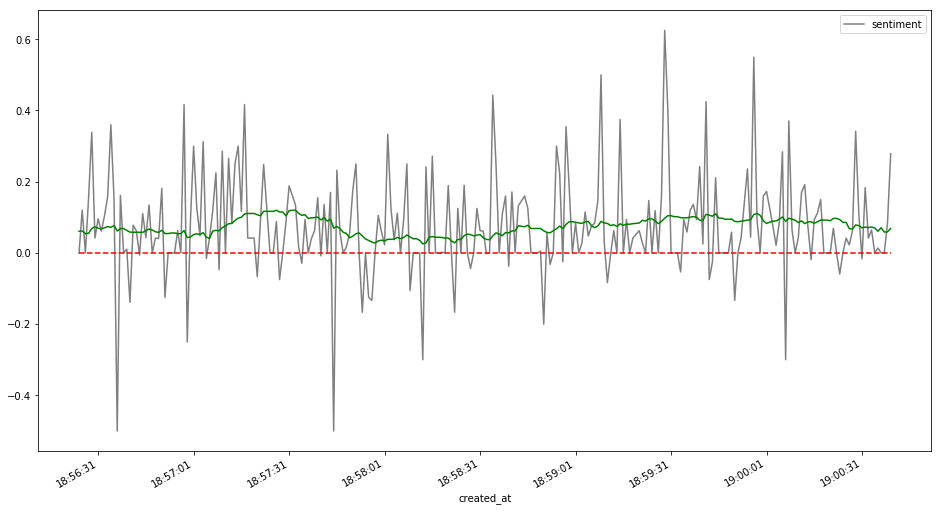

In [238]:
rcParams['figure.figsize'] = 16, 9

dfS[-250:].plot(kind='line', color='grey')

ax1 = dfS['sentiment'].rolling(30, min_periods=1).mean()[-250:].plot(kind='line', color='g')
plt.plot(dfS.index[-250:], [0]*len(dfS.index[-250:]), '--r')

In [232]:
[range(5)]

[range(0, 5)]

In [104]:
stop = set(stopwords.words('english'))  # predefined list of "uninteresting" words

counter = Counter()

def nlargest(n, word_scores):
    """ Wrapper around heapq to return the n words with the largest count."""
    # word_scores: index 0=>word, 1=>count
    return heapq.nlargest(n, word_scores, key=lambda x: x[1])

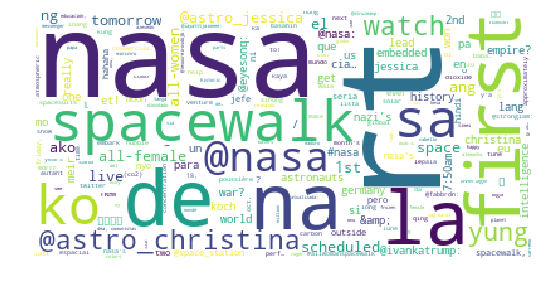

In [222]:
rcParams['figure.figsize'] = 9, 6
DISPLAY_EVERY = 100

try:
    for k in range(len(L)):
        try:
            tweet = L[k]['text']
            for word in tweet.lower().split():
                if word not in stop and 'http' not in word:
                    counter[word] += 1
            if k % DISPLAY_EVERY == (DISPLAY_EVERY - 1):
                wordcloud = WordCloud(background_color='white'#, collocations=False #, 
                                      #width=1600, height=800
                                     ).fit_words(counter)
                plt.axis("off")
                display.clear_output(wait=True)
                plt.imshow(wordcloud)
                display.display(plt.gcf())
        except:
            pass
    display.clear_output(wait=True)
except KeyboardInterrupt:
    pass

In [239]:
nlargest(10, counter.items())

[('rt', 13207),
 ('nasa', 8510),
 ('de', 2460),
 ('na', 2447),
 ('la', 2270),
 ('first', 2225),
 ('spacewalk', 1726),
 ('ko', 1585),
 ('sa', 1581),
 ('@astro_christina', 1425)]

In [240]:
#L = [x for x in L if x]

In [241]:
#Collect only the tweets
T = []
for tweet in L:
    T.append(tweet['text'])

In [242]:
BATCH_SIZE = 20
CLUSTER_SIZE = 4

kmeans = MiniBatchKMeans(n_clusters=CLUSTER_SIZE)

def batch(iterable, size):
    """ batch("ABCDEFG", 3) -> ABC DEF G """
    sourceiter = iter(iterable)
    while True:
        batchiter = islice(sourceiter, size)
        yield chain([next(batchiter)], batchiter)

In [243]:
with open("dictnostops.txt") as fh:
    words = [line.strip() for line in fh.readlines()]
    word_to_index = { word: k for k, word in enumerate(words) }

In [244]:
def wordclouds(wordcounts):
    wordclouds = [WordCloud().fit_words(Counter({k:v for (k,v) in dict(counts).items() if v > 0})) for counts in wordcounts]
    fig, axes = plt.subplots(2,2)
    display.clear_output(wait=True)
    for k, (ax, wordcloud) in enumerate(zip(axes.flatten(), wordclouds)):
        ax.axis("off")
        ax.imshow(wordcloud)
        ax.set_title("Topic %d" % k)
    display.display(fig)
    fig.clear()

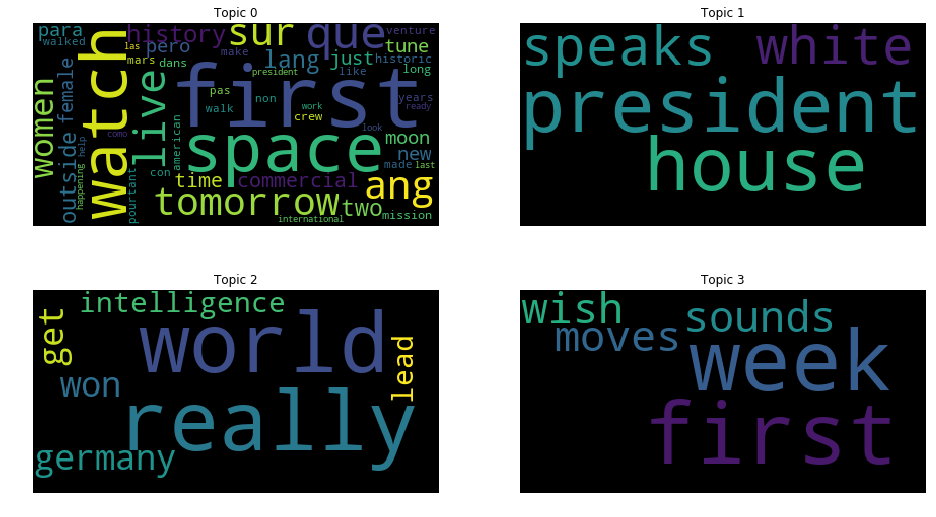

/Users/Nel/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: generator 'batch' raised StopIteration
  from ipykernel import kernelapp as app


<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

In [245]:
try:
    for tweets in batch(T, BATCH_SIZE):
        mat = sp.sparse.dok_matrix((BATCH_SIZE, len(words)))
        for row, tweet in enumerate(tweets):
            for word in tweet.lower().split():
                if word in word_to_index:
                    mat[row, word_to_index[word]] = 1.
        kmeans.partial_fit(mat.tocsr())
        wordcounts = [nlargest(50, zip(words, kmeans.cluster_centers_[i])) for i in range(kmeans.n_clusters)]
        wordclouds(wordcounts)
except:
    pass

In [119]:
df.shape

(4998, 11)

In [246]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['text'])

In [247]:
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)

In [248]:
X1 = svd.fit_transform(X)

In [249]:
#print(svd.explained_variance_ratio_) 

In [250]:
print(svd.explained_variance_ratio_.sum())

0.412006395391


In [251]:
#print(svd.singular_values_)

In [252]:
clustering = DBSCAN(eps=.5, min_samples=5).fit(X1)

In [253]:
df['dbscan'] = clustering.labels_

In [254]:
df[['text', 'dbscan']].sort_values(by='dbscan')

text  dbscan
4766                                            NASAüòçüòçüò≠      -1
3094  RT @StationCDRKelly: Two astronauts are doing ...      -1
3674  RT @StationCDRKelly: Two astronauts are doing ...      -1
1507                                               NASA      -1
1094         Space walk tomorrow morning üöÄ!!!!!!!!!!!!!      -1
3434  RT @StationCDRKelly: Two astronauts are doing ...      -1
4874  RT @MikaKYV365: NASA astronauts Christina Koch...      -1
5368  RT @StationCDRKelly: Two astronauts are doing ...      -1
3449  RT @spacecentre: üë©‚ÄçüöÄüë©‚ÄçüöÄ We'll be watching the ...       0
3416  Kung wan tawsan nayn handred to di q bibilen H...       0
3417  #AllWomanSpacewalk Good luck ladies and entire...       0
3418  Watch these NASA astronauts perform the 1st al...       0
3420  @a_areglado Ingat ka po, isipin mo lang si Mat...       0
3421                              sana ol nasa pic diba       0
3422  RT @mingiarts: gente??? a nasa recentemente co...       0
3424  @NASA @sachi_bbsr @NASAInSight @MarsCuriosity ...       0
3425  RT @NYTScience: Two women astronauts, Jessica ...       0
3426  RT @HiRISE: HiPOD 17 Oct 2019: Enigmatic Canyo...       0
3428  RT @CA_AstroComm: Today, for the first time in...       0
3429                                                ü§£ü§£ü§£       0
3430  #NASA | „É¶„Éã„Çª„ÉÉ„ÇØ„Çπ„ÅßÁùÄ„Çå„ÇãNASA„Éë„Éº„Ç´„ÅåÂÖ•Ëç∑üõ∞Ô∏è\n‚úîÔ∏è https://t.c...       0
3432  New NASA images  revealed how dire the Amazon ...       0
3433  Kaso nasa 150k pala. Tapos 18 na. Kaya pa ba s...       0
3415  @shirrianafhaye nasa practice ako #masipaglang...       0
3452  Tune in now! First All Female spacewalk!! üòçüöÄNA...       0
3436  RT @getSejunified: Nasa langit na ba ako? üò©‚ù§Ô∏è ...       0
3437       Dayawi ako buntag kaina kuman yaunk nasa ink       0
3438  NASA says five asteroids will skim past Earth ...       0
3439  RT @GinalynSaycon: ang tanong sino nagpapasaya...       0
3442  HAPPENING SOON: #NASA conducting its first all...       0
...                                                 ...     ...
5903  RT @BillNye: Space brings out the best in us. ...      91
5068  RT @BillNye: Space brings out the best in us. ...      91
5906  RT @mishacollins: This morning, history was ma...      92
5577  RT @mishacollins: This morning, history was ma...      92
5078  RT @mishacollins: This morning, history was ma...      92
5496  RT @mishacollins: This morning, history was ma...      92
5491  RT @mishacollins: This morning, history was ma...      92
5147  RT @mishacollins: This morning, history was ma...      92
5247  RT @mishacollins: This morning, history was ma...      92
5346  RT @mishacollins: This morning, history was ma...      92
5345  RT @mishacollins: This morning, history was ma...      92
5305  RT @mishacollins: This morning, history was ma...      92
5635  RT @mishacollins: This morning, history was ma...      92
5195  RT @_Jessification_: First ever all female #sp...      93
5412  RT @_Jessification_: First ever all female #sp...      93
5110  RT @_Jessification_: First ever all female #sp...      93
5310  RT @_Jessification_: First ever all female #sp...      93
5260  RT @_Jessification_: First ever all female #sp...      93
5190  RT @_Jessification_: First ever all female #sp...      93
5701  RT @Space_Station: From Mission Control Center...      94
5904  RT @Space_Station: From Mission Control Center...      94
5691  RT @Space_Station: From Mission Control Center...      94
5314  RT @Space_Station: From Mission Control Center...      94
5613  RT @Space_Station: From Mission Control Center...      94
5573  RT @Space_Station: From Mission Control Center...      94
5431  RT @Space_Station: From Mission Control Center...      94
5976  RT @Space_Station: From Mission Control Center...      94
5859  RT @Space_Station: From Mission Control Center...      94
5625  RT @Space_Station: From Mission Control Center...      94
5462  RT @Space_Station: From Mission Control Center... 

In [256]:
df[df['dbscan'] == 0]['text']

0       RT @riahfab: Ikaw na nasa bus/jeep na antok na...
2                   nasa panaginip nanaman kita kanina:))
4       NASA's Hubble Telescope Gives Best Look Yet at...
5       @SpideyChief Not to mention how NASA recently ...
8       RT @wfryer: Getting ready for #STEAM night in ...
9       RT @elmundoes: La NASA ya tiene los trajes par...
10      RT @NASA_SLS: As NASA goes forward to the Moon...
11      RT @SmartTalentUY: #Agenda &gt;&gt;&gt; üõ∞üöÄ Est...
19      RT @SinEmbargoMX: C√°mara de la NASA capta la m...
20      RT @NASA: üëã @NASAInSight\n üëã @MarsCuriosity\nT...
21      RT @weatherindia: . @NASA is planning to land ...
22      RT @scosh_svnit: NASA's Hubble Telescope Gives...
23      RT @NASAJPL: Ruptures in Ridgecrest\n \nUsing ...
24      Our very own Katelyn Hertel, (@Katers_Potaters...
25      RT @elgranqenk: Primer cometa interestelar cap...
27      NASA to Televise First All-Female Spacewalk, H...
29      halaaa parang ako lang kapag nasa jeep HAHAHAH...
3

## Geospatial Analysis

## We extracted the location information from the tweets that had it so let's see how many did.

In [257]:
df.location.dropna()

1336    {'type': 'Point', 'coordinates': [112.72278627...
3457    {'type': 'Point', 'coordinates': [121.05386257...
Name: location, dtype: object

In [258]:
#df = df.drop(3350, axis=0)

## That's not very promising. What else can we do to get geospatial information? We can look into the 'place' key.

In [259]:
df.place.dropna()

248     {'id': '3b77caf94bfc81fe', 'url': 'https://api...
249     {'id': '0087ad0f1b6dfcc8', 'url': 'https://api...
267     {'id': '3b77caf94bfc81fe', 'url': 'https://api...
313     {'id': '01516da6022dca08', 'url': 'https://api...
321     {'id': '521b6f591c4b3ce8', 'url': 'https://api...
377     {'id': '006523c50dfe9086', 'url': 'https://api...
459     {'id': '01e93ed535e05b29', 'url': 'https://api...
485     {'id': '013379ee5729a5e6', 'url': 'https://api...
661     {'id': '07d9ec9cc0086001', 'url': 'https://api...
778     {'id': '3797791ff9c0e4c6', 'url': 'https://api...
868     {'id': '01d7c74272e5eafe', 'url': 'https://api...
961     {'id': '5579f6b17e36847b', 'url': 'https://api...
1012    {'id': '003d47f62835a9f1', 'url': 'https://api...
1063    {'id': '00fc4c873d8a5e32', 'url': 'https://api...
1094    {'id': 'd6819fe60643ebc1', 'url': 'https://api...
1117    {'id': '4ec01c9dbc693497', 'url': 'https://api...
1155    {'id': '0fa65e5e6fbf3eb8', 'url': 'https://api...
1214    {'id':

In [260]:
df.place.loc[248]

{'id': '3b77caf94bfc81fe',
 'url': 'https://api.twitter.com/1.1/geo/id/3b77caf94bfc81fe.json',
 'place_type': 'city',
 'name': 'Los Angeles',
 'full_name': 'Los Angeles, CA',
 'country_code': 'US',
 'country': 'United States',
 'bounding_box': {'type': 'Polygon',
  'coordinates': [[[-118.668404, 33.704538],
    [-118.668404, 34.337041],
    [-118.155409, 34.337041],
    [-118.155409, 33.704538]]]},
 'attributes': {}}

In [261]:
df['place'].dropna()

248     {'id': '3b77caf94bfc81fe', 'url': 'https://api...
249     {'id': '0087ad0f1b6dfcc8', 'url': 'https://api...
267     {'id': '3b77caf94bfc81fe', 'url': 'https://api...
313     {'id': '01516da6022dca08', 'url': 'https://api...
321     {'id': '521b6f591c4b3ce8', 'url': 'https://api...
377     {'id': '006523c50dfe9086', 'url': 'https://api...
459     {'id': '01e93ed535e05b29', 'url': 'https://api...
485     {'id': '013379ee5729a5e6', 'url': 'https://api...
661     {'id': '07d9ec9cc0086001', 'url': 'https://api...
778     {'id': '3797791ff9c0e4c6', 'url': 'https://api...
868     {'id': '01d7c74272e5eafe', 'url': 'https://api...
961     {'id': '5579f6b17e36847b', 'url': 'https://api...
1012    {'id': '003d47f62835a9f1', 'url': 'https://api...
1063    {'id': '00fc4c873d8a5e32', 'url': 'https://api...
1094    {'id': 'd6819fe60643ebc1', 'url': 'https://api...
1117    {'id': '4ec01c9dbc693497', 'url': 'https://api...
1155    {'id': '0fa65e5e6fbf3eb8', 'url': 'https://api...
1214    {'id':

## Not all tweets have a 'place' key but there are definitely more of those than with a location. Inside 'place' there are coordinates for a geographical bounding box so let's compute its centroid and use that as a point of reference for location.

In [262]:
df1 = df[['place', 'text']].dropna().reset_index()
df1['centroid_lat'] = df1.apply(lambda x: np.array(x['place']['bounding_box']['coordinates'][0]).mean(axis=0)[0], 1)
df1['centroid_lon'] = df1.apply(lambda x: np.array(x['place']['bounding_box']['coordinates'][0]).mean(axis=0)[1], 1)

df1 = df1.groupby(['centroid_lat', 'centroid_lon'])['text'].count().reset_index()
df1.columns = ['centroid_lat', 'centroid_lon', 'count']

#### What are the most common centroids?

In [263]:
df1.sort_values(by='count', ascending=False)

centroid_lat  centroid_lon  count
46    120.983987     14.591457      3
29    -73.968542     40.780709      2
17    -83.804475     27.698682      2
4    -118.411907     34.020789      2
50    121.062736     14.683012      2
33    -46.595546    -23.682803      2
25    -77.014398     38.898603      2
51    121.069057     14.306870      1
49    121.039260     14.584755      1
48    121.033212     14.546499      1
47    121.025487     14.306330      1
0    -122.923516     47.064528      1
53    121.090374     14.278017      1
45    120.969501     14.430456      1
44    120.818031     13.984376      1
43    120.728789     15.192721      1
42    120.588440     16.402280      1
41    112.724706     -7.275803      1
40    104.016823      1.050769      1
52    121.082345     14.583306      1
54    121.104887     14.646971      1
38     11.244817     43.780709      1
63    123.046833     14.079588      1
69    138.792756    -35.097686      1
68    135.512242     35.008375      1
67    125.443261      7.317582      1
66    123.942861     10.355342      1
65    123.765449     13.143562      1
64    123.247827     13.640892      1
62    122.549703     10.729419      1
..           ...           ...    ...
2    -122.330602     47.614817      1
3    -119.827182     39.512436      1
5    -117.730006     33.560742      1
6    -111.931711     34.168253      1
7    -110.915573     32.189391      1
8    -104.976767     39.534794      1
9     -97.817354     26.176254      1
10    -95.085380     29.560645      1
11    -92.131274     34.751936      1
12    -89.266508     39.739300      1
13    -89.017567     42.257146      1
14    -88.193290     41.434970      1
15    -87.732013     41.833585      1
16    -84.260673     33.752887      1
18    -82.400308     34.783014      1
19    -80.737633     28.258804      1
20    -80.650764     28.586010      1
21    -80.201097     44.080757      1
22    -79.420865     38.003376      1
23    -79.272570     43.629311      1
24    -77.090869     38.817380      1
26    -75.483936     40.591825      1
27    -74.315005     40.569527      1
28    -74.278855     40.266520      1
30    -71.683502     42.036939      1
31    -49.288460    -25.495249      1
32    -47.436633    -23.470006      1
34    -43.441578    -22.911422      1
1    -122.555439     38.093358      1
70    153.369361    -27.954221      1

[71 rows x 3 columns]

### Where are users located according to their bios?

In [264]:
df.groupby('user_location')['text'].count().sort_values(ascending=False)

user_location
United States                      86
Republic of the Philippines        65
Los Angeles, CA                    32
USA                                29
Washington, DC                     23
Paris, France                      22
California, USA                    21
Philippines                        21
New York, NY                       21
Venezuela                          19
Earth                              17
Texas, USA                         17
Comunidad de Madrid, Espa√±a        17
üáµüá≠                                 16
Houston, TX                        15
France                             15
Florida, USA                       15
India                              13
Canada                             12
London, England                    12
San Diego, CA                      12
Weiser, ID                         11
Chicago, IL                        10
Brasil                             10
#Stranraer, #SouthWestScotland     10
Atlanta, GA                  

In [265]:
df['location'].dropna()

1336    {'type': 'Point', 'coordinates': [112.72278627...
3457    {'type': 'Point', 'coordinates': [121.05386257...
Name: location, dtype: object

In [266]:
# Go through all tweets and add locations to 'coordinates' dictionary
coordinates = {'latitude': [], 'longitude': []}
for index, row in df.iterrows():
    try:
        
        #location = geolocator.geocode(user_loc)
        # If coordinates are found for location
        if row['location']['coordinates']:
            coordinates['latitude'].append(row['location']['coordinates'][0])
            coordinates['longitude'].append(row['location']['coordinates'][1])
            
    # If too many connection requests
    except:
        pass

In [267]:
coordinates

{'latitude': [112.72278627, 121.05386257],
 'longitude': [-7.27586109, 14.62204492]}

### Lets now map the information we have from tweet's location and bounding box centroids.

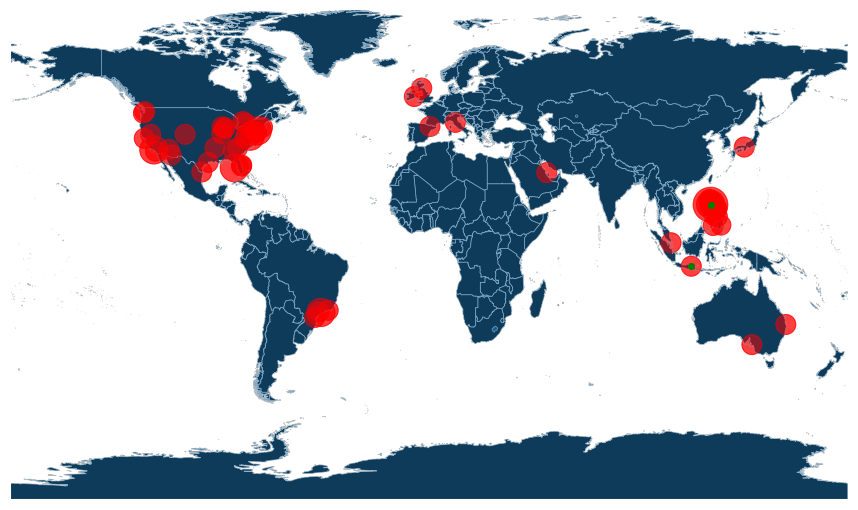

In [268]:
shp_link = './ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp'
shp = ps.open(shp_link)
some = [True for i in ps.open(shp_link)] #bool(rdm.getrandbits(1))


fig = figure(figsize=(15,9))

base = maps.map_poly_shp(shp)
base.set_facecolor('black')
base.set_linewidth(0.75)
base.set_edgecolor('0.8')
some = maps.map_poly_shp(shp, which=some)
some.set_alpha(0.5)
some.set_linewidth(0.)
ptsC = scatter(df1['centroid_lat'], df1['centroid_lon'], s=400*df1['count'], alpha=.5)
ptsC.set_color('red')

pts = scatter(coordinates['latitude'], coordinates['longitude'])
pts.set_color('green')

ax = maps.setup_ax([base, some, ptsC, pts], [shp.bbox, shp.bbox, shp.bbox, shp.bbox])

fig.add_axes(ax)
show()

(2000, 10)

In [274]:
#df.to_csv('dataT.csv', index=False)

In [ ]:
#use the sentiment to color

In [526]:
df['user_description']

0            Have Faith, Hope and Love üòáüíï || Astrophile ‚ú®
1       üá≥üá¥‚ù§Ô∏è I love ivanka trump üåπüá∏üá™ l love you üíïü•Ä sor...
2                                                       üíë
3         Conservative Veterans wife/born again Christian
4       Society for Cultivation of Sciences and Humani...
5       Sci-fi fan, dinosaur enthusiast, and weeb. Ama...
6                                                    None
7       love food , dogs , President Trump and his fam...
8                                                    None
9                           Entre Sevilla y Gran Canaria.
10      Go NASA!!!Go Bar√ßa!!Two different but determin...
11      Soci√≥loga, interesada en generar sinergias ent...
12                                                   None
13                                No boi I have a smile üòä
14      Horsesüêé | Entrepreneurship, Social Development...
15                                                   None
16      Born in Motown/Hocke

In [66]:
#dfA = pd.read_csv('dataT.csv')

In [70]:
def Converter(x):
    try:
        return eval(x)
    except:
        None

In [71]:
#dfA['raw_data'] = dfA.apply(lambda x: Converter(x['raw_data']), 1)

In [74]:
#L = list(dfA['raw_data']) + L

In [ ]:
#L = [x for x in L if x]